In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
import warnings
warnings.simplefilter('ignore')
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
import os
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()
os.listdir('../data')

['dataset.pkl',
 'PA_201605-2020001更新R10(20200602).csv',
 'PA_201605-2020001更新R9(20200508).csv',
 'tag_cleaned.csv',
 'tag盤點表20200423.xlsx',
 'tag盤點表20200602R1.xlsx',
 'train_cleaned.csv']

# load data

In [2]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag = tag.loc[tag.category=='可控制因子']

In [3]:
data = joblib.load('../data/dataset.pkl')
data.keys()

dict_keys(['state', 'action', 'output', 'stream', 'idx', 'mm_state', 'mm_action', 'mm_output', 'mm_stream', 'state_col', 'action_col', 'output_col', 'stream_col'])

# tensor data

In [4]:
state = torch.FloatTensor(data['state']).cuda()
action = torch.FloatTensor(data['action']).cuda()
output = torch.FloatTensor(data['output']).cuda()
stream = torch.FloatTensor(data['stream']).cuda()

# split data

In [5]:
sp1 = int(len(state)*0.8)
sp2 = int(len(state)*0.9)
print(sp1,sp2)

99769 112240


# data_iter

In [6]:
train = torch.utils.data.TensorDataset(state[:sp1],action[:sp1],output[:sp1],stream[:sp1])
valid = torch.utils.data.TensorDataset(state[sp1:sp2],action[sp1:sp2],output[sp1:sp2],stream[sp1:sp2])
test = torch.utils.data.TensorDataset(state[sp2:],action[sp2:],output[sp2:],stream[sp2:])

train_iter = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)

In [7]:
print(action.shape)
time_step = action.shape[1]
num_sensor = action.shape[2]

torch.Size([124712, 36, 12])


# Construct the neural network

In [8]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.time_step = time_step
        self.num_sensor = num_sensor
        self.h_size = 64
        
        self.output_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.stream_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.conv_layer = nn.Sequential(nn.Conv1d(self.num_sensor,self.h_size-1,kernel_size = 36),
                                        nn.ReLU(),
                                       )
        
        self.fc_layer = nn.Sequential(nn.Linear(497,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,self.h_size),
                                         )
        
    def forward(self,state,action):
        batch_size = state.shape[0]
        
        # action have two path,path_1 and path_2
        action_1 = self.conv_layer(action.permute(0,2,1)).reshape(batch_size,-1)
        action_2 = action.reshape(batch_size,-1)
        
        # combine two path action_1,action_2
        action = torch.cat((action_1,action_2),dim=-1)
        
        # combine state action
        combine = torch.cat((state,action),dim=-1)
        
        # fc forward
        combine = self.fc_layer(combine)
        
        # get output and stream
        output = self.output_layer(combine)
        stream = self.stream_layer(combine)
        
        return F.sigmoid(output),F.sigmoid(stream)

In [9]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0.1)
        except:
            pass

In [10]:
net = Critic().cuda()
net.apply(init_weights)

Critic(
  (output_layer): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (stream_layer): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (conv_layer): Sequential(
    (0): Conv1d(12, 63, kernel_size=(36,), stride=(1,))
    (1): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=497, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
)

# forward test

In [11]:
a,b = net(state,action)
print(a.shape)
print(b.shape)

torch.Size([124712, 1])
torch.Size([124712, 1])


# tensorboard

In [12]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (test.tensors[0:2]))

# loss and opt

In [13]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)

In [14]:
def loss_function(output,stream,target_output,target_stream):
    loss1 = ((output-target_output)**2).sum()
    loss2 = ((stream-target_stream)**2).sum()
    return 0.5*loss1 + 0.0*loss2

# train and eval

In [15]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for state,action,output,stream in train_iter:
            output_pred,stream_pred = net(state,action)
            loss = loss_function(output_pred,stream_pred,output,stream)
            train_loss += loss.item()
            i += 1
            
            # update model
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # eval model (afater update model)
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for state,action,output,stream in valid_iter:
                output_pred,stream_pred = net(state,action)
                loss = loss_function(output_pred,stream_pred,output,stream)
                val_loss += loss.item()
                j += 1
        
        # caculate avg_loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best_model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            best_net = deepcopy(net) #backup the model(deepcopy)
            print('model recorded!')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(
            epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    return best_net.eval()

model recorded!
epochs 0 train_avg_loss 0.1181 valid_avg_loss 0.1207
model recorded!
epochs 1 train_avg_loss 0.0550 valid_avg_loss 0.0731
model recorded!
epochs 2 train_avg_loss 0.0519 valid_avg_loss 0.0356
epochs 3 train_avg_loss 0.0529 valid_avg_loss 0.0520
epochs 4 train_avg_loss 0.0509 valid_avg_loss 0.0910
epochs 5 train_avg_loss 0.0504 valid_avg_loss 0.0457
epochs 6 train_avg_loss 0.0494 valid_avg_loss 0.1155
epochs 7 train_avg_loss 0.0495 valid_avg_loss 0.0547
epochs 8 train_avg_loss 0.0484 valid_avg_loss 0.0877
epochs 9 train_avg_loss 0.0487 valid_avg_loss 0.0361
epochs 10 train_avg_loss 0.0474 valid_avg_loss 0.1534
epochs 11 train_avg_loss 0.0474 valid_avg_loss 0.0405
epochs 12 train_avg_loss 0.0459 valid_avg_loss 0.0588
epochs 13 train_avg_loss 0.0462 valid_avg_loss 0.0438
epochs 14 train_avg_loss 0.0462 valid_avg_loss 0.0965
epochs 15 train_avg_loss 0.0458 valid_avg_loss 0.0401
epochs 16 train_avg_loss 0.0455 valid_avg_loss 0.0598
epochs 17 train_avg_loss 0.0442 valid_avg_lo

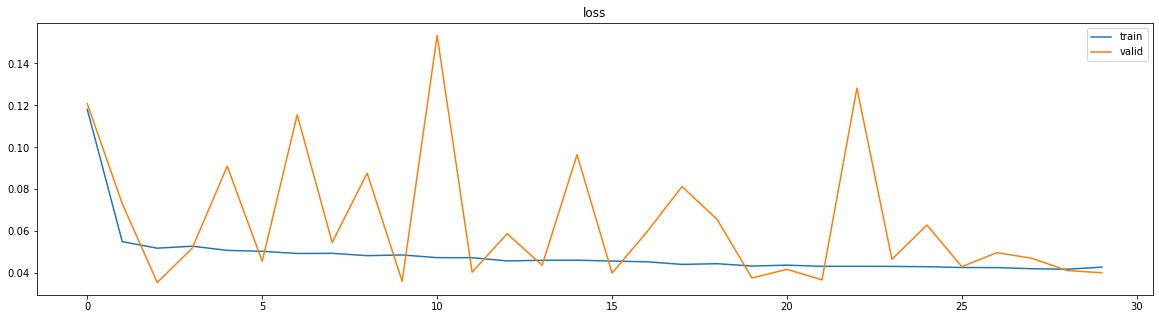

In [16]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=30)

# make prediction

In [17]:
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

def mape(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()*100

In [18]:
def make_prediction(state,action,output,streamn):
    
    y_pred = net(state,action)[0].detach().cpu().numpy()
    y_pred = data['mm_output'].inverse_transform(y_pred).ravel()
    
    y_pred2 = net(state,action)[1].detach().cpu().numpy()
    y_pred2 = data['mm_stream'].inverse_transform(y_pred2)
    
    y_real = output.detach().cpu().numpy()
    y_real = data['mm_output'].inverse_transform(y_real).ravel()
    
    y_real2 = stream.detach().cpu().numpy()
    y_real2 = data['mm_stream'].inverse_transform(y_real2)
    
    feed = action.detach().cpu().numpy()
    temp = [data['mm_action'].inverse_transform(feed[i]) for i in range(len(feed))]
    feed = np.array(temp)[:,:,0][:,0]
    
    table = pd.DataFrame()
    table['0619'] = feed
    table['0997_real'] = y_real
    table['0997_pred'] = y_pred
    table['真實單耗'] = feed/y_real
    table['預測單耗'] = feed/y_pred
    table['真實蒸氣'] = y_real2
    table['預測蒸氣'] = y_pred2
    
    return table

In [19]:
def make_metric(table):
    
    metric = pd.DataFrame(index=[0],columns=['R2(出料)','RMSE(單耗)','MAPE(單耗)'])
    metric['R2(出料)'] = r2_score(table['0997_real'],table['0997_pred'])
    metric['RMSE(單耗)'] = sqrt(mean_squared_error(table['真實單耗'],table['預測單耗']))
    metric['MAPE(單耗)'] = mape(table['真實單耗'],table['預測單耗'])
    metric.index.name = '出料'
    
    metric2 = pd.DataFrame(index=[0],columns=['R2','RMSE','MAPE'])
    metric2['R2'] = r2_score(table['真實蒸氣'],table['預測蒸氣'])
    metric2['RMSE'] = sqrt(mean_squared_error(table['真實蒸氣'],table['預測蒸氣']))
    metric2['MAPE'] = mape(table['真實蒸氣'],table['預測蒸氣'])
    metric2.index.name = '蒸氣'
    
    return metric,metric2

# train metric

In [20]:
state ,action, output, stream = train_iter.dataset.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(單耗),MAPE(單耗)
出料,,,
0,0.932527,0.013812,1.051368


In [21]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,-35.330937,16586.59314,35.549384


# test metric

In [22]:
state ,action, output, stream = test.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(單耗),MAPE(單耗)
出料,,,
0,0.915929,0.019323,1.31891


In [23]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,-19.493581,10577.974097,27.163219


# save 

In [24]:
joblib.dump(net,'../model/Critic.pkl')
print('save done!')

save done!
